In [1]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools import DuckDuckGoSearchRun

In [2]:
load_dotenv()
openai_model=ChatOpenAI(model="gpt-4")

In [3]:
openai_model.invoke("hi")

AIMessage(content='Hello! How can I assist you today?\n', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-BTWUqUBr0gKIqFf9E1oyKOIpnHtKB', 'finish_reason': 'stop', 'logprobs': None}, id='run-d653b180-79f7-402e-a6b7-d35f0a1fda77-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [4]:
from langchain_groq import ChatGroq
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [5]:
groq_model.invoke("hi")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 6, 'total_tokens': 22, 'completion_time': 0.058181818, 'prompt_time': 0.003481631, 'queue_time': 22.248302371, 'total_time': 0.061663449}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'stop', 'logprobs': None}, id='run-623f4826-8973-4f7d-ae9e-280fc9eecc57-0', usage_metadata={'input_tokens': 6, 'output_tokens': 16, 'total_tokens': 22})

In [6]:
search_tool = DuckDuckGoSearchRun()

In [7]:
search_tool.invoke("what is a gdp of india?")

"India ranks 5th in the world's GDP rankings for 2025. The country's economy is diverse and rapidly growing, fueled by key sectors such as information technology, services, agriculture, and ... India is now the fifth-largest economy in the world GDP rankings list due to its strong economic foundations, thriving domestic demand, careful financial management, high saving rates and ... Annual GDP Estimates and Growth Rates. Real GDP or GDP at Constant Prices is estimated to attain a level of ₹184.88 lakh crore in the financial year 2024-25, against the Provisional Estimate of GDP for the year 2023-24 of ₹173.82 lakh crore. The growth rate in Real GDP during 2024-25 is estimated at 6.4% as compared to 8.2% in 2023-24. India is the 5th largest economy globally. India attained the highest 5th rank in 2021 and the lowest 17th in 1991. India contributes 3.70% of the entire world's GDP. India's share of the world economy increased from 1.08 percent in 1993 to the current estimate of 3.70 percen

In [9]:
repl = PythonREPL()

In [10]:
code = """
x = 5
y = x * 2
print(y)
"""

In [11]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [19]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [20]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [14]:
make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    )

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [15]:
"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [21]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [22]:
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    
    research_agent = create_react_agent(
    groq_model,
    tools=[search_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
    )
    
    result = research_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "chart_generator")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    
    return Command(update={"messages": result["messages"]},goto=goto)

In [23]:
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    
    chart_agent = create_react_agent(
    groq_model,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
    )
    result = chart_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "researcher")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    
    return Command(update={"messages": result["messages"]},goto=goto)

In [24]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

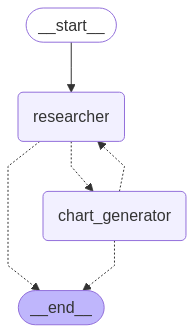

In [25]:
display(Image(app.get_graph().draw_mermaid_png()))

In [26]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})

{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='39efa98d-f667-4d68-8120-d382c24759a1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rgnw', 'function': {'arguments': '{"query":"UK GDP past 3 years"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 214, 'prompt_tokens': 280, 'total_tokens': 494, 'completion_time': 0.778181818, 'prompt_time': 0.015778139, 'queue_time': 10.622951395, 'total_time': 0.793959957}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4d8b1f5f-7e97-4f2f-9c74-5a24abe3f2fd-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'UK GDP past 3 years'}, 'id': 'call_rgnw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 280, 'output_toke